In [1]:
from zipfile import ZipFile
import msgpack
import warnings
from pprint import pprint
from joblib import Parallel, delayed
from typing import Dict, Any

import pandas as pd

In [2]:
from dask.distributed import Client
client = Client(n_workers=8)
client

/Users/scott/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59269 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:59270 Dashboard: http://127.0.0.1:59269/status,Cluster Workers: 8 Cores: 8 Memory: 16.00 GiB


In [44]:
import viz

In [45]:
N_TRAIN = 17100
# N_TRAIN = 19800

In [46]:
# %%time
# about 9s for 730 files
# rares = []
# with ZipFile("_io/embeddings.zip") as zf:
#     for fname in zf.namelist():
#         with zf.open(fname) as f:
#             raw = f.read()
#         rare = msgpack.loads(raw)
#         if "n_search" in rare["meta"].get("meta__fname", ""):
#             rare["meta"]["sampling"] = "salmon-tste"
#         if rare["meta"]["n_train"] == N_TRAIN:
#             if rare["meta"]["sampling"] == "salmon-tste":
#                 continue
#             print(rare["meta"].get("meta__fname", "[random]"))
#             rares.append(rare)
       
from typing import List
def _get_embeddings(zip_fname: str) -> List[dict]:
    rares = []
    with ZipFile(zip_fname) as zf:
        for fname in zf.namelist():
            with zf.open(fname) as f:
                raw = f.read()
            rare = msgpack.loads(raw)
            if rare["meta"]["sampling"] == "salmon" and rare["meta"]["meta__alg"] == "TSTE":
                rare["meta"]["sampling"] = "salmon-tste"
            fname = rare["meta"].get("meta__fname", "[random]")
            if "rate" in fname:
                # fname = 'next/io/2021-05-24/rate=0.5_responses.msgpack'
                rate = fname.split("/")[-1].replace("_responses.msgpack", "")
                s = "dict(" + rate + ")"
                d = eval(s)
                rare["meta"].update(d)
            if "ARR-" in fname:
                i = fname.find("ARR-")
                fname = fname[i + 4:]
                j = fname.find("_")
                rate = fname[:j]
                rare["meta"]["rate"] = float(rate)

            if rare["meta"]["n_train"] == N_TRAIN:
                if rare["meta"]["sampling"] == "salmon-tste":
                    print(rare["meta"]["n_train"], fname)
                    rares.append(rare)
    return rares

v1 = _get_embeddings("_io/embeddings-v1-save.zip")
v2 = _get_embeddings("_io/embeddings-v2.zip")
rares = v1 + v2

17100 salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=100000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=10000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=100-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=10000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=100000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=300-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=1000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=100-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=300000-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=30-1_responses.csv.zip
17100 salmon/io/2021-05-26-search/TSTE-n_search=100

In [47]:
mrares = [{**rare["meta"], **h} for rare in rares for h in rare["history"]]

In [48]:
df = pd.DataFrame(mrares)
df.columns

Index(['len_X_train', 'len_X_test', 'n_train', 'n_test', 'n', 'd', 'num_ans',
       'sampling', 'shuffle_seed', 'noise_model', 'est__random_state',
       'est__max_epochs', 'est__noise_model', 'est__module__mu',
       'est__verbose', 'meta__alg', 'meta__vary', 'meta__fname', 'pf_calls',
       'num_answers', 'model_updates', 'num_grad_comps', 'answers_bytes',
       'score_train', 'loss_train', 'k', 'elapsed_time', 'train_data',
       'max_epochs', 'verbose', 'ident', '_epochs', 'last_score', 'score_test',
       'loss_test', '_elapsed_time'],
      dtype='object')

In [49]:
df.columns

Index(['len_X_train', 'len_X_test', 'n_train', 'n_test', 'n', 'd', 'num_ans',
       'sampling', 'shuffle_seed', 'noise_model', 'est__random_state',
       'est__max_epochs', 'est__noise_model', 'est__module__mu',
       'est__verbose', 'meta__alg', 'meta__vary', 'meta__fname', 'pf_calls',
       'num_answers', 'model_updates', 'num_grad_comps', 'answers_bytes',
       'score_train', 'loss_train', 'k', 'elapsed_time', 'train_data',
       'max_epochs', 'verbose', 'ident', '_epochs', 'last_score', 'score_test',
       'loss_test', '_elapsed_time'],
      dtype='object')

In [50]:
df.meta__fname.iloc[0]

'salmon/io/2021-05-26-search/TSTE-n_search=3000-1_responses.csv.zip'

In [51]:
def _get_rate(s: str) -> int:
    fname = s.split("/")[-1]
    rate = fname.replace("-1_responses.csv.zip", "").replace("TSTE-n_search=", "")
    return int(rate)
    
    
import numpy as np
df["meta__n_search"] = df.meta__fname.apply(_get_rate)
df["meta__n_search_log"] = np.log10(df["meta__n_search"])

In [53]:
import altair as alt
alt.Chart(df[df.est__noise_model == "CKL"], title="Offline optimization").mark_line().encode(
    x="_epochs",
    y=alt.Y("score_test", scale=alt.Scale(domain=(0.78, 0.835), clamp=True)),
    color=alt.Color("meta__n_search", scale=alt.Scale(type="log", scheme="blueorange")),
)

alt.Chart(...)

(0.81, 0.835)

(0.81, 0.835)

(0.81, 0.835)

(0.81, 0.835)

(0.81, 0.835)

(0.81, 0.835)

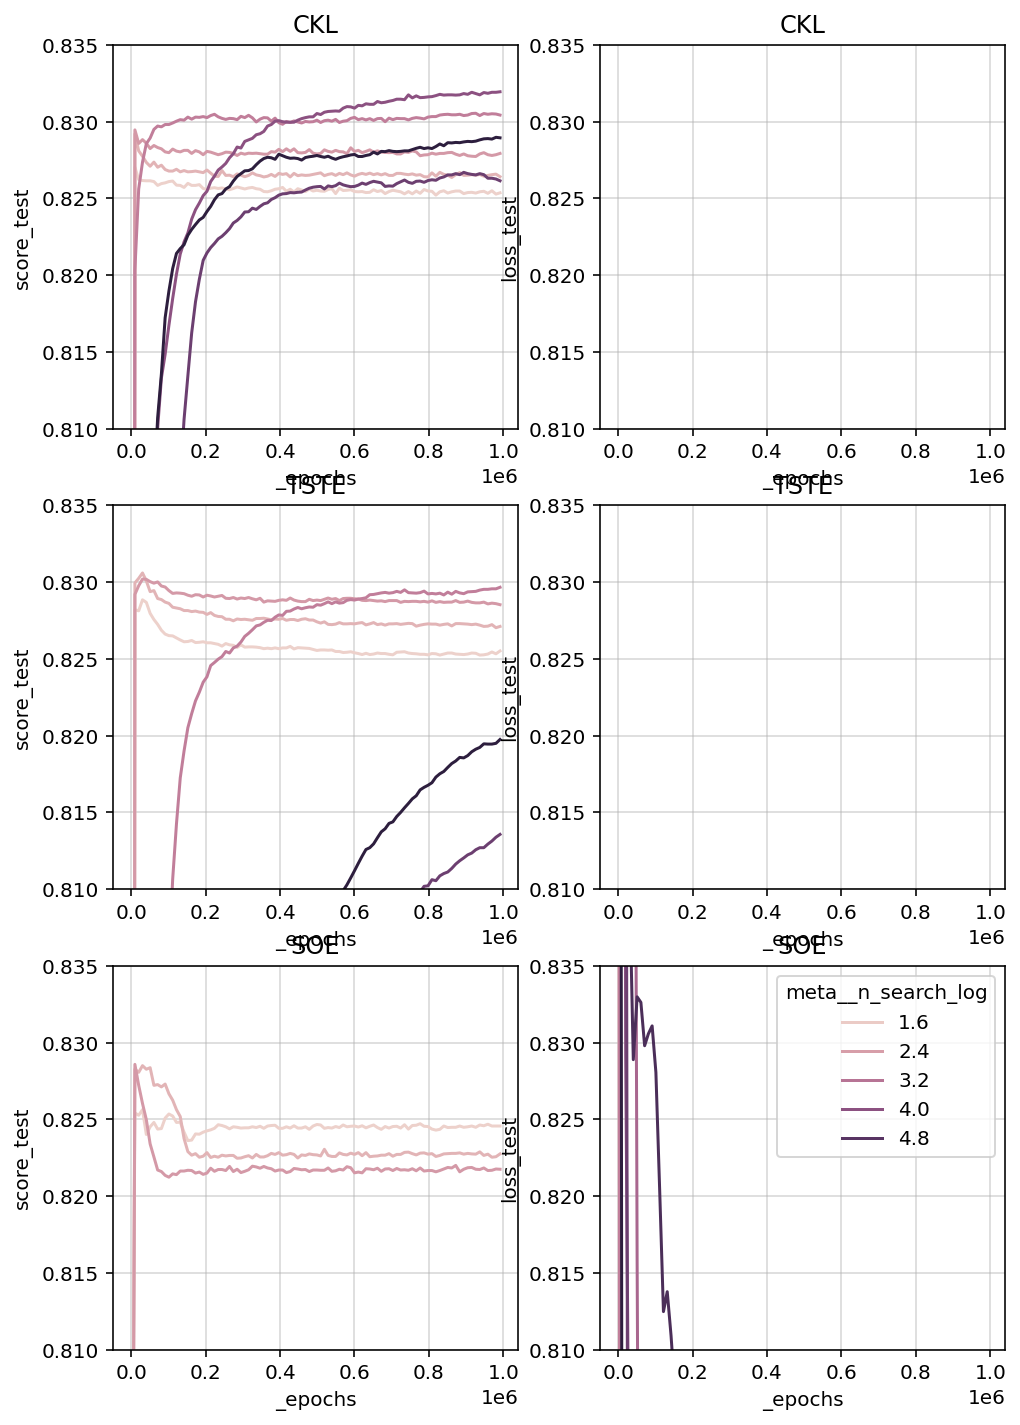

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 4
NOISE_MODELS = ["CKL", "TSTE", "SOE"]
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(2 * w, 3* w))

for nm, row in zip(NOISE_MODELS, axs):
    
    kwargs = dict(
        x="_epochs",
#         hue="meta__fname",
        hue="meta__n_search_log",
        ci="sd",
        data=df[df.est__noise_model == nm],
    )
    ax = sns.lineplot(y="score_test", ax=row[0], **kwargs)
    ax.set_title(nm)
    # ax.set_ylim(0.75, 0.85)

    ax = sns.lineplot(y="loss_test", ax=row[1], **kwargs)
    ax.set_title(nm)
    # ax.set_ylim(0.75, 0.85)

for k, ax in enumerate(axs.flatten()):
    ax.grid(alpha=0.5)
    if ax.legend_ and k != 5:
        ax.legend_.remove()
    ax.set_ylim(0.81, 0.835)

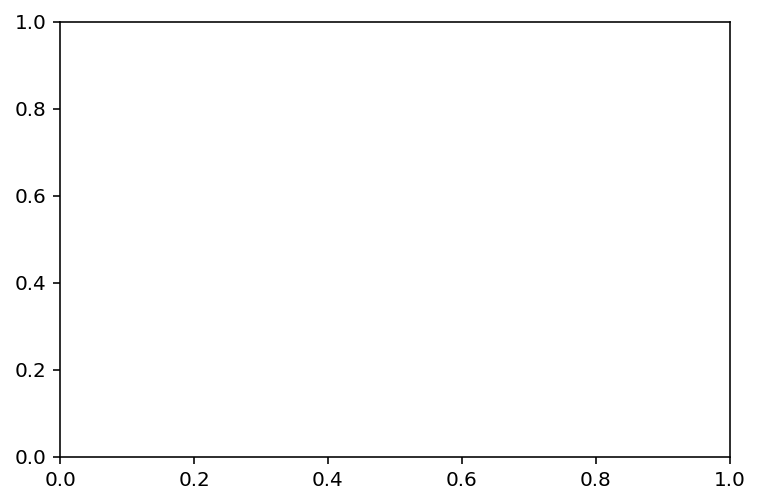

In [15]:
 fig, ax = plt.subplots()

# for rare in rares:
#     _df = pd.DataFrame(rare["history"])
#     _ = _df.plot(x="_epochs", y="score_test", ax=ax)

In [16]:
from generate_embeddings import _X_test
import targets
T = targets.get(90)
X_test = _X_test(T)

In [18]:
rares[0].keys()

dict_keys(['embedding', 'meta', 'performance', 'history'])

In [19]:
%%time 
# about 7.5 seconds with 700 files
def _cook(rare: Dict[str, Any], T, X_test) -> Dict[str, Any]:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        mrare = viz._stats(rare, T=T, X_test=X_test)
    return mrare

T_f = client.scatter(T)
X_test_f = client.scatter(X_test)
futures = client.map(viz._stats, rares, T=T_f, X_test=X_test_f)
data = client.gather(futures)

CPU times: user 448 ms, sys: 24.5 ms, total: 473 ms
Wall time: 1.95 s


In [20]:
df = pd.DataFrame(data)
df.head()

,accuracy,nn_diff_median,nn_diff_mean,nn_acc,avg_items_closer_than_NN,nn_diff_p99,nn_diff_p98,nn_diff_p95,nn_diff_p90,nn_diff_p80,...,meta__noise_model,meta__est__random_state,meta__est__max_epochs,meta__est__noise_model,meta__est__module__mu,meta__est__verbose,meta__meta__sampling_seed,meta__meta__alg,meta__meta__vary,meta__meta__fname
0,0.806800,4.0,4.077778,0.111111,8.200000,10.33,9.22,8.00,8.0,6.0,...,CKL,400,1000000,CKL,0.05,10000,1.0,random,NaN,NaN
1,0.792133,3.0,3.644444,0.166667,7.977778,12.11,11.22,9.00,7.1,6.0,...,SOE,400,1000000,SOE,NaN,10000,1.0,random,NaN,NaN
2,0.810517,3.0,3.944444,0.166667,11.288889,14.11,13.22,12.00,8.1,6.2,...,CKL,400,1000000,CKL,0.05,10000,4.0,random,NaN,NaN
3,0.808767,3.0,3.333333,0.166667,5.555556,11.33,10.22,10.00,7.1,5.0,...,TSTE,400,1000000,TSTE,NaN,10000,1.0,random,NaN,NaN
4,0.783750,4.0,4.900000,0.122222,10.133333,26.88,18.20,12.65,9.1,7.0,...,SOE,400,1000000,SOE,NaN,10000,6.0,random,NaN,NaN


In [21]:
df["meta__sampling"].unique()

array(['random', 'salmon'], dtype=object)

In [22]:
salmon = (df["meta__sampling"] == "salmon") & (df["meta__meta__alg"] == "ARR")
next_ = df["meta__sampling"] == "next"
random = df["meta__sampling"] == "random"

for idx in [salmon, next_, random]:
    print(idx.sum())

show = df[salmon | next_ | random]
print(len(show))
show = show[show["meta__est__noise_model"] == "CKL"]
print(len(show))

2
0
5
7
4


(0.0, 2848.5)

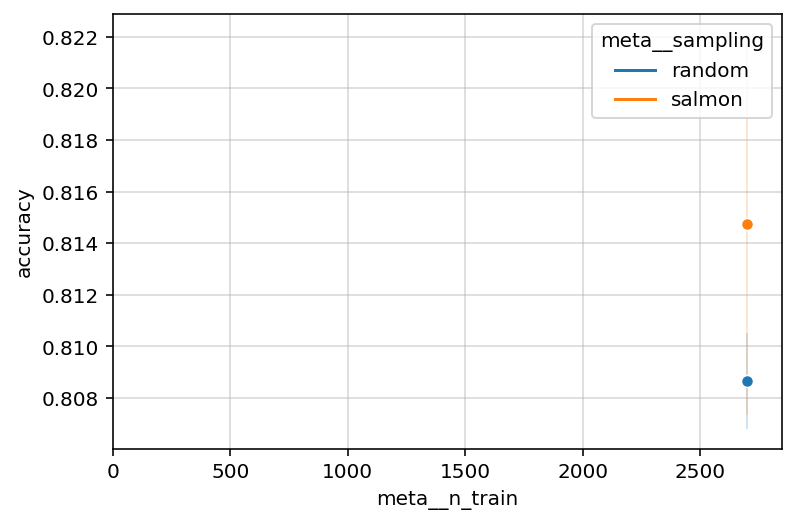

In [24]:
import seaborn as sns

ax = sns.lineplot(
    x="meta__n_train",
    y="accuracy",
    hue="meta__sampling",
    marker="o",
    data=show,
)
ax.grid(alpha=0.5)
# ax.set_ylim(0.75, 0.84)
ax.set_xlim(0, None)

In [13]:
# df[[c for c in df.columns if "meta__" in c]]
df.columns

Index(['accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25', 'nn_acc_radiu

In [66]:
n_search = (df["meta__sampling"] == "salmon") & (df["meta__meta__alg"] == "TSTE")
random = df["meta__sampling"] == "random"
# show = df[n_search | random].copy()
show = df[n_search].copy()
print(len(show))

230


In [67]:
import numpy as np
def _get_n_search(s: str) -> int:
    if isinstance(s, float) and np.isnan(s):
        return 0.1
    t = s.split("/")[-1].replace("-1_responses.csv.zip", "")
    n_search = t.replace("TSTE-n_search=", "")
#     return n_search
    return int(n_search)

show["n_search"] = show["meta__meta__fname"].apply(_get_n_search)
show["log10(n_search)"] = np.log10(show["n_search"])

(0.0, 15000.0)

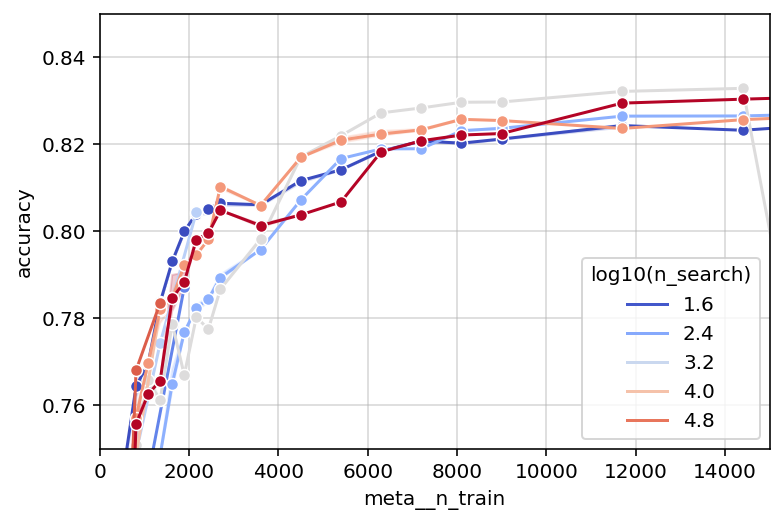

In [71]:
ax = sns.lineplot(
    x="meta__n_train",
    y="accuracy",
    hue="log10(n_search)",
    data=show,
    palette="coolwarm",
    marker="o",
)
ax.set_ylim(0.75, 0.85)
ax.grid(alpha=0.5)
ax.set_xlim(0, 15_000)